## CAM(Class Activation Map)과 Grad-CAM
특성을 추출하는 CNN 네트워크 뒤에 GAP(Global Average Pooling)와 소프트맥스 레이어(softmax layer)가 붙는 형태로 구성되어야 한다. 반면 Grad-CAM은 이런 제약이 없다.  
  
CAM과 Grad-CAM 두 가지를 모두 구현해본다.

CAM은 **클래스에 대한 활성화 정도를 나타낸 지도**이다. 따라서 기본적으로 모델은 **분류**를 수행하는 모델이어야 한다.

## 모듈 및 데이터 불러오기

In [2]:
# Tensorflow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

import copy
import cv2
from PIL import Image

In [3]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

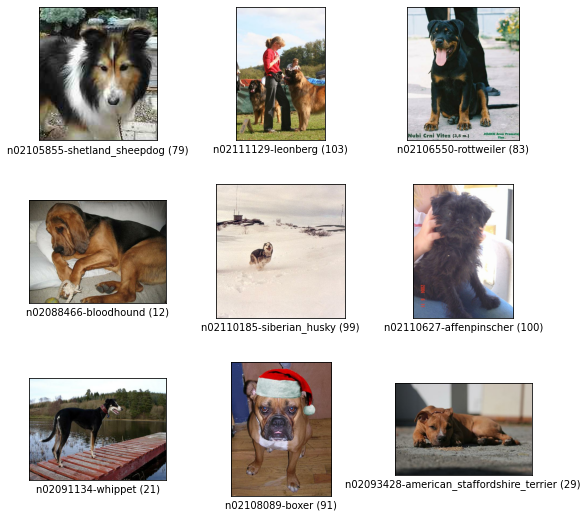

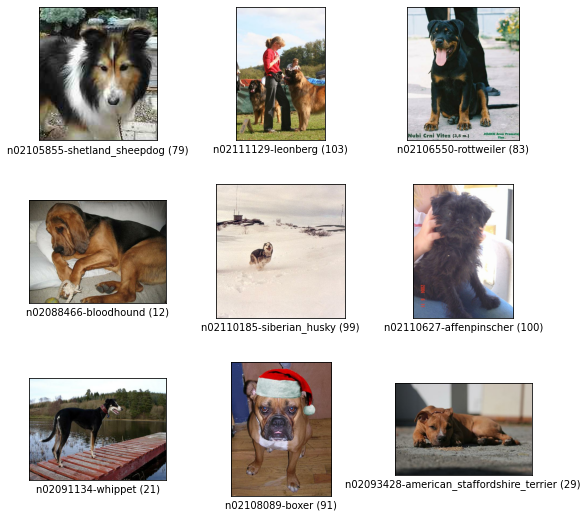

In [5]:
tfds.show_examples(ds_train, ds_info)

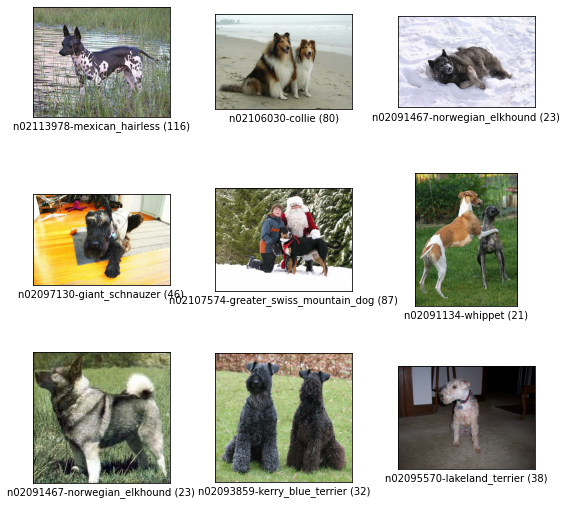

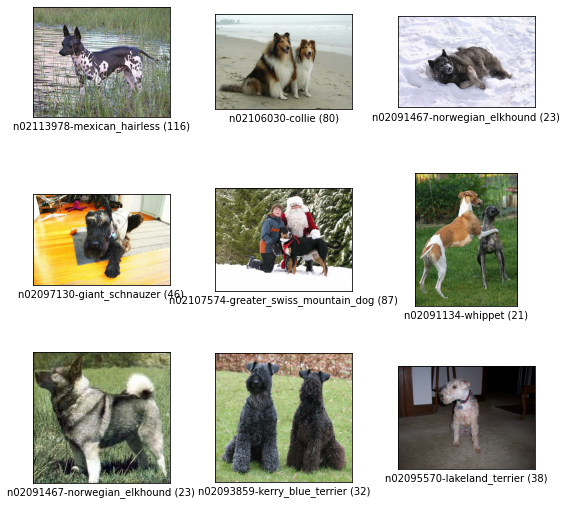

In [6]:
tfds.show_examples(ds_test, ds_info)

### 물체의 위치정보
* 원본 이미지 위에 물체의 위치정보가 어떻게 시각화되어 있는지 확인하기위해 ds_info의 feature를 확인한다.
* image 등 외에 'bbox'가 존재한다. bbox는 바운딩박스로, 다음 사진과 같이 물체의 위치를 사각형 영역으로 표기하는 방법이다.
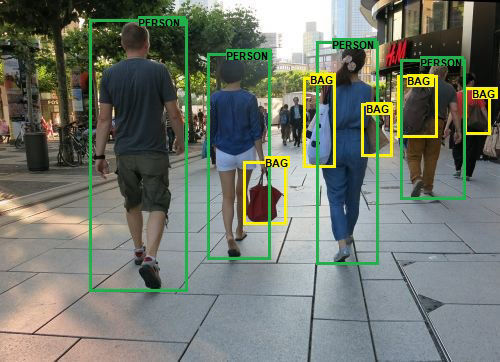

#### 바운딩 박스를 표시하는 방법들
* 'xywh' 바운딩박스 중심점을 x,y로 표기하고, 사각형의 너비 w와 높이 h를 표기한다.
  * 예) (x_center, y_center, width, height)
  * x,y가 중심점이 아니라 좌측 상단의 점을 가리킬수도 있다.
* 'minmax'는 바운딩박스를 이루는 좌표의 최소값과 최대값을 통해 표기하는 방법이다.
  * 예) (x_min, x_max, y_min, y_max)
  * 좌표의 절대값이 아니라, 전체 이미지의 너비와 높이를 기준으로 normalize한 상대적인 값을 표기하는 것이다.

In [7]:
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'image/filename': Text(shape=(), dtype=tf.string),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=120),
    'objects': Sequence({
        'bbox': BBoxFeature(shape=(4,), dtype=tf.float32),
    }),
})

## CAM 및 Grad-CAM을 위한 모델 만들기
* CAM을 얻어내기 위한 모델을 만들기 위해 ImageNet 데이터에 훈련된 ResNet50을 기반으로 하고, 이후 pooling layer 뒤에 소프트맥스 레이어를 붙여 Grad-CAM 모델을 만든다.

In [8]:
num_classes = ds_info.features['label'].num_classes

# Pre-trained model 생성
base_model = keras.applications.resnet50.ResNet50(
    include_top=False, #Imagenet 분류기 fully connected layer 제거
    weights = 'imagenet',
    input_shape = (224,224,3),
    pooling = 'avg', # GAP을 적용
)

# 분류기 덧붙이기
x = base_model.output
preds = keras.layers.Dense(num_classes, activation='softmax')(x)
cam_model = keras.Model(inputs=base_model.input, outputs=preds)

* summary에서 conv5_block3_out의 output이 feature map이 된다.
* 이 feature map에 Global average pooling을 하여 feature의 크기를 줄이고, 줄어든 feature 전체에 Dense layer를 붙여 classification을 수행하게 된다.

In [9]:
cam_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

## CAM 모델 학습하기
* 학습 데이터와 검증 데이터에 normalizing과 resizing을 포함한 간단한 전처리를 normalize_and_resize_img()에서 수행하고, 이를 포함하여 apply_normalize_on_dataset()에서 배치를 구성한다.
* input에 이전과는 다르게 bbox 정보가 포함되어있지만, 지금 수행해야 할 CAM 모델의 학습에는 필요가 없으므로 normalize_and_resize_img 과정에서 제외해 준다. 
* CAM 모델은 object detection이나 segmentation에도 활용될 수 있지만, bounding box 같은 직접적인 라벨을 사용하지 않고 weakly supervised learning을 통해 물체 영역을 간접적으로 학습시키는 방식이기 때문이다.

In [10]:
def normalize_and_resize_img(input):
    # Normalizes images : `uint8` -> `float32`
    image = tf.image.resize(input['image'], [224,224])
    input['image'] = tf.cast(image,tf.float32)/255.
    return input['image'], input['label']

def apply_normalize_on_dataset(ds, is_test = False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img,
        num_parallel_calls=2
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [11]:
# 데이터셋에 전처리와 배치처리를 적용한다.
ds_train_norm = apply_normalize_on_dataset(ds_train)
ds_test_norm = apply_normalize_on_dataset(ds_test)

# 구성된 배치의 모양을 확인해 본다.
for input in ds_train_norm.take(1):
    image, label = input
    print(image.shape)
    print(label.shape)

(16, 224, 224, 3)
(16,)


In [12]:
tf.random.set_seed(2021)
cam_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

In [13]:
history_cam_model = cam_model.fit(
    ds_train_norm,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=20,
    validation_data=ds_test_norm,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 365s 450ms/step - loss: 3.1636 - accuracy: 0.2792 - val_loss: 3.4558 - val_accuracy: 0.2022
Epoch 2/20
750/750 [==============================] - 348s 465ms/step - loss: 0.9453 - accuracy: 0.7377 - val_loss: 1.2491 - val_accuracy: 0.6332
Epoch 3/20
750/750 [==============================] - 339s 452ms/step - loss: 0.3477 - accuracy: 0.9169 - val_loss: 0.9326 - val_accuracy: 0.7252
Epoch 4/20
750/750 [==============================] - 339s 453ms/step - loss: 0.0926 - accuracy: 0.9893 - val_loss: 0.8992 - val_accuracy: 0.7374
Epoch 5/20
750/750 [==============================] - 340s 453ms/step - loss: 0.0326 - accuracy: 0.9992 - val_loss: 0.8857 - val_accuracy: 0.7496
Epoch 6/20
750/750 [==============================] - 340s 453ms/step - loss: 0.0189 - accuracy: 0.9990 - val_loss: 0.8965 - val_accuracy: 0.7421
Epoch 7/20
750/750 [==============================] - 340s 454ms/step - loss: 0.0120 - accuracy: 1.0000 - val_loss: 0.9106 -

In [14]:
import os

cam_model_path = os.getenv('HOME') + '/aiffel/class_activation_map/cam_model.h5'
cam_model.save(cam_model_path)

### CAM 생성
* CAM 생성 작업은 데이터셋 배치 단위가 아니라 개별 이미지 데이터 단위로 이루어지기 때문에 get_one()함수로 데이터셋에서 한장씩 뽑을 수 있도록 한다.

In [15]:
def get_one(ds):
    ds = ds.take(1)
    sample_data = list(ds.as_numpy_iterator())
    bbox = sample_data[0]['objects']['bbox']
    image = sample_data[0]['image']
    label = sample_data[0]['label']
    return sample_data[0]

In [17]:
import os
cam_model_path = os.getenv('HOME') + '/aiffel/class_activation_map/cam_model.h5'
cam_model = tf.keras.models.load_model(cam_model_path)

### 입력 이미지와 동일한 크기의 CAM을 반환하는 함수
* CAM을 생성하기 위해서는 다음 세가지가 필요하다.
  1. 특성 맵
  2. 클래스 별 확률을 얻기 위한 소프트맥스 레이어의 가중치
  3. 원하는 클래스의 출력값

* 또, 이미지에서 모델이 어떤 부분을 보는지 직관적으로 확인하려면 네트워크에서 나온 CAM을 입력 이미지 사이즈와 같게 만들어 함께 시각화해야 한다.

* generation_cam()을 구현하기 위해 아래에서는 conv_output와 같이 특정 레이어의 결과값을 output으로 받기 위해 새로운 모델을 정의하고, feedforward를 거친 후 CAM을 계산하도록 구현한다.
* 마지막에는 입력 이미지의 크기에 맞춰 CAM을 resize한다.

In [18]:
def generate_cam(model, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    # 학습한 모델에서 원하는 layer의 output을 얻기 위해서 모델의 input과 output을 새롭게 정의해준다.
    # model.layers[-3].output에서는 우리가 필요로 하는 GAP 이전 Convolution layer의 output을 얻을 수 있다.
    cam_model = tf.keras.models.Model([model.inputs], [model.layers[-3].output, model.output])
    conv_outputs, predictions = cam_model(tf.expand_dims(img_tensor, 0))
    
    conv_outputs = conv_outputs[0, :, :, :]
    class_weights = model.layers[-1].get_weights()[0] # 마지막 모델의 weight activation을 가져온다.
    
    cam_image = np.zeros(dtype=np.float32, shape=conv_outputs.shape[0:2])
    for i, w in enumerate(class_weights[:, class_idx]):
        # W*f 를 통해 class별 activation map을 계산한다.
        cam_image += w*conv_outputs[:,:,i]
        
    cam_image /= np.max(cam_image) # activation score를 normalize한다.
    cam_image = cam_image.numpy()
    cam_image = cv2.resize(cam_image,(width, height)) # 원래 이미지 크기로 resize한다.
    return cam_image

11


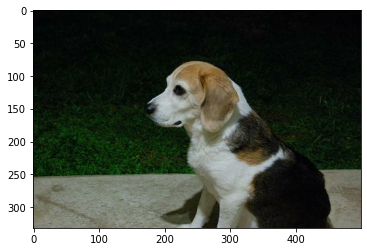

In [19]:
# CAM을 확인하기 위해서 한장 고르기
item = get_one(ds_test)    # 학습에 사용하지 않은 테스트셋에서 한 장 뽑음
print(item['label'])       # 라벨 출력 (라벨이 견종이 아니라 숫자로 되어있다)
plt.imshow(item['image'])
plt.show()

In [20]:
def visualize_cam_on_image(src1, src2, alpha=0.5):
    beta = (1.0 - alpha)
    merged_image = cv2.addWeighted(src1, alpha, src2, beta, 0.0)
    return merged_image

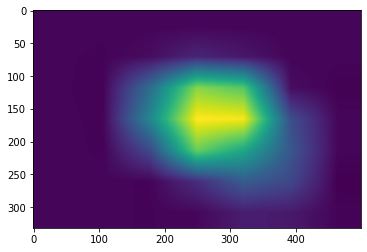

In [21]:
# CAM 확인
cam_image = generate_cam(cam_model, item)
plt.imshow(cam_image)
plt.show()

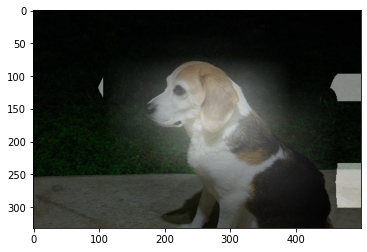

In [22]:
origin_image = item['image'].astype(np.uint8)
cam_image_3channel = np.stack([cam_image*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(cam_image_3channel, origin_image)
plt.imshow(blended_image)
plt.show()

## Grad-CAM
* 적용 모델을 유연하게 선택할 수 있는 Grad-CAM 특성 상 모델은 그대로 사용한다.

### Grad-CAM을 반환하는 함수
* grad_cam은 관찰을 원하는 레이어와 정답 클래스에 대한 예측값 사이의 Gradient를 구하고 여기에 GAP 연산을 적용함으로써 관찰 대상이 되는 레이어의 채널별 가중치를 구한다.
* 최종 CAM 이미지를 구하기 위해서는 레이어의 채널별 가중치(weight)와 레이어에서 나온 채널 별 특성 맵을 가중합해주어 cam_image를 얻게 된다.
* CAM함수와 달리 Grad-CAM은 어떤 레이어든 CAM 이미지를 뽑아낼 수 있으므로 Gradient 계산을 원하는 관찰 대상 레이어 activation_layer를 뽑아서 쓸 수 있도록 activation_layer의 이름을 받고 이를 활용해야 한다.

In [23]:
def generate_grad_cam(model, activation_layer, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    # Grad-CAM에서도 CAM과 같이 특정 레이어의 output을 필요로 하므로 모델의 input과 output을 새롭게 정의한다.
    # 이 때 원하는 레이어가 다를 수 있으니 해당 레이어의 이름으로 찾은 후 output으로 추가한다.
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(activation_layer).output, model.output])
    
    # Gradient를 얻기 위해 tape를 사용한다.
    with tf.GradientTape() as tape:
        conv_output, pred = grad_model(tf.expand_dims(img_tensor, 0))
        
        loss = pred[:, class_idx] # 원하는 class (여기서는 정답으로 활용)
        output = conv_output[0] # 원하는 layer의 output을 얻는다.
        grad_val = tape.gradient(loss, conv_output)[0] # 예측값에 따른 Layer의 gradient를 얻는다.
        
    weights = np.mean(grad_val, axis=(0,1)) # gradient의 GAP으로 class별 weight를 구한다.
    grad_cam_image = np.zeros(dtype=np.float32, shape=conv_output.shape[0:2])
    for k, w in enumerate(weights):
        # 각 class별 weight와 해당 layer의 output을 곱해 class activation map을 얻는다.
        grad_cam_image += w * output[:,:,k]
        
    grad_cam_image /= np.max(grad_cam_image)
    grad_cam_image = grad_cam_image.numpy()
    grad_cam_image = cv2.resize(grad_cam_image, (width, height))
    return grad_cam_image

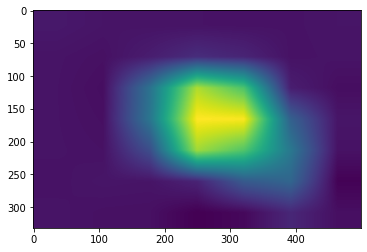

In [24]:
grad_cam_image = generate_grad_cam(cam_model, 'conv5_block3_out', item)
plt.imshow(grad_cam_image)
plt.show()

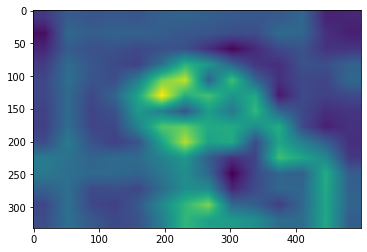

In [25]:
grad_cam_image = generate_grad_cam(cam_model,'conv4_block3_out', item)
plt.imshow(grad_cam_image)
plt.show()

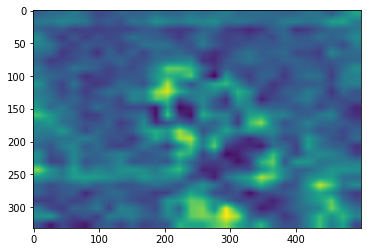

In [26]:
grad_cam_image = generate_grad_cam(cam_model, 'conv3_block3_out', item)
plt.imshow(grad_cam_image)
plt.show()

## Detection

### get_bbox()함수
* get_bbox() 함수는 바운딩 박스를 만들기 위해 score_thresh를 받아 역치값 이하의 바운딩 박스는 없앤다.
* 그 다음 OpenCV의 fineContours()와 minAreaRect()로 사각형을 찾는다.
* 이 때, rotated_rect라는 회전된 바운딩 박스를 얻을 수 있다.
* boxPoints()로 이를 꼭지점으로 바꾸어준다.
* 마지막에는 int 자료형으로 변환해 준다.

In [27]:
def get_bbox(cam_image, score_thresh=0.05):
    low_indicies = cam_image <= score_thresh
    cam_image[low_indicies] = 0
    cam_image = (cam_image*255).astype(np.uint8)
    
    contours,_ = cv2.findContours(cam_image,cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnt = contours[0]
    rotated_rect = cv2.minAreaRect(cnt)
    rect = cv2.boxPoints(rotated_rect)
    rect = np.int0(rect)
    return rect

In [28]:
rect = get_bbox(cam_image)
rect

array([[ 68, 193],
       [196, -24],
       [507, 158],
       [379, 377]])

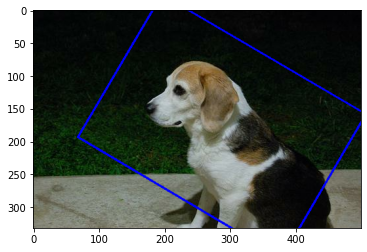

In [29]:
image = copy.deepcopy(item['image'])
image = cv2.drawContours(image, [rect], 0, (0,0,255),2)
plt.imshow(image)
plt.show()

### Intersection Over Union
* 지금까지 CAM과 Grad-CAM 두 가지 방법을 통해 바운딩박스를 얻을 수 있었다.
* 그렇다면 정답 데이터인 바운딩 박스와 이를 어떻게 비교, 평가할 수 있을까?
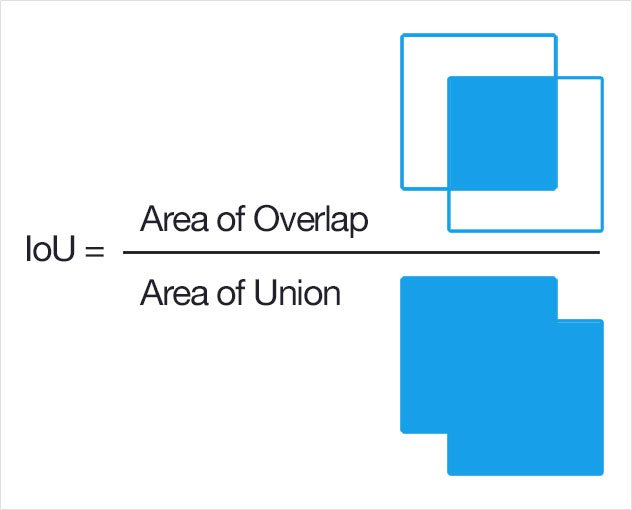
* IoU(Intersection Over Union)는 두 영역의 교집합인 intersection 영역의 넓이를 두 영역의 합집합인 union 영역으로 나누어준 값이다.
* 이를 통해 찾고자 하는 물건의 절대적인 면적과 상관없이, 영역을 정확하게 잘 찾아내었는지의 상대적인 비율을 구할 수 있으므로, 모델이 영역을 잘 찾았는지 비교하는 좋은 지표가 된다.

In [30]:
# rect의 좌표는 (x,y) 형태로, bbox는 (y_min, x_min, y_max, x_max)의 normalized 형태로 주어진다.
def rect_to_minmax(rect, image):
    bbox = [
        rect[:,1].min()/float(image.shape[0]), # bounding box의 y_min
        rect[:,0].min()/float(image.shape[1]), # bounding box의 y_min
        rect[:,1].max()/float(image.shape[0]), # bounding box의 y_min
        rect[:,0].max()/float(image.shape[1])  # bounding box의 y_min
    ]
    
    return bbox

In [31]:
pred_bbox = rect_to_minmax(rect, item['image'])
pred_bbox

[-0.07228915662650602, 0.136, 1.1355421686746987, 1.014]

In [32]:
item['objects']['bbox']

array([[0.22289157, 0.326     , 0.9909639 , 0.916     ]], dtype=float32)

In [33]:
def get_iou(boxA, boxB):
    y_min = max(boxA[0], boxB[0])
    x_min = max(boxA[1], boxB[1])
    y_max = min(boxA[2], boxB[2])
    x_max = min(boxA[3], boxB[3])
    
    interArea = max(0, x_max - x_min) * max(0, y_max - y_min)
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    iou = interArea / float(boxAArea + boxBArea - interArea)
    
    return iou

In [34]:
get_iou(pred_bbox, item['objects']['bbox'][0])

0.42732012900367644